                x1           x2           x3           x4
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.036297     0.025735    -1.525553     1.506925
std       1.615487     0.554702     0.879283     0.767912
min      -4.164033    -1.539778    -4.785984    -1.284518
25%      -1.410406    -0.369342    -1.925804     0.992156
50%       0.125286     0.035024    -1.534219     1.488318
75%       1.484590     0.423894    -1.122190     2.034763
max       3.610197     1.675817     2.110392     4.074556


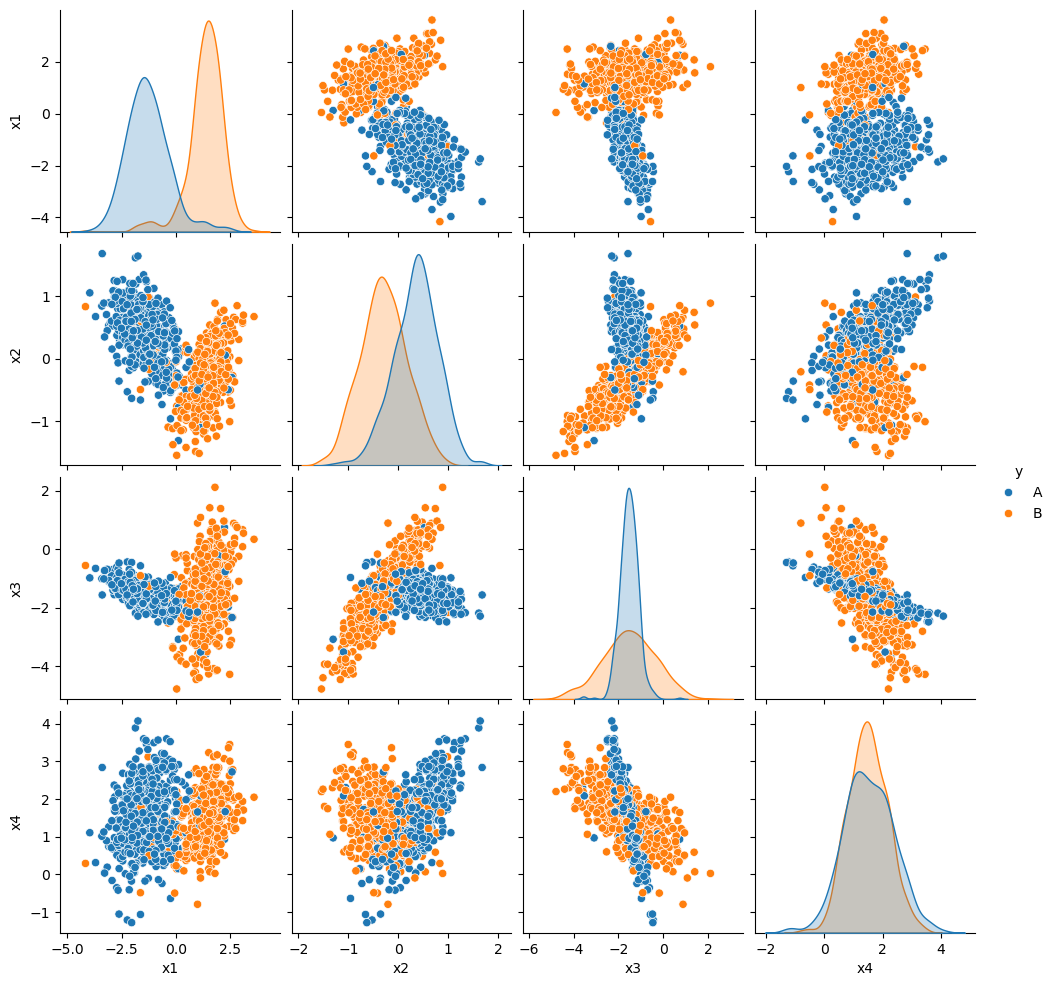

Resultados de kNN:
   k  accuracy        f1
0  1     0.907  0.906404
1  3     0.948  0.948203
2  5     0.951  0.951261
3  7     0.949  0.949119
4  9     0.949  0.949037
Resultados de ANN:
   neurons  accuracy        f1
0        5     0.934  0.935678
1       10     0.938  0.939185
2       15     0.938  0.939275
3       20     0.939  0.940115


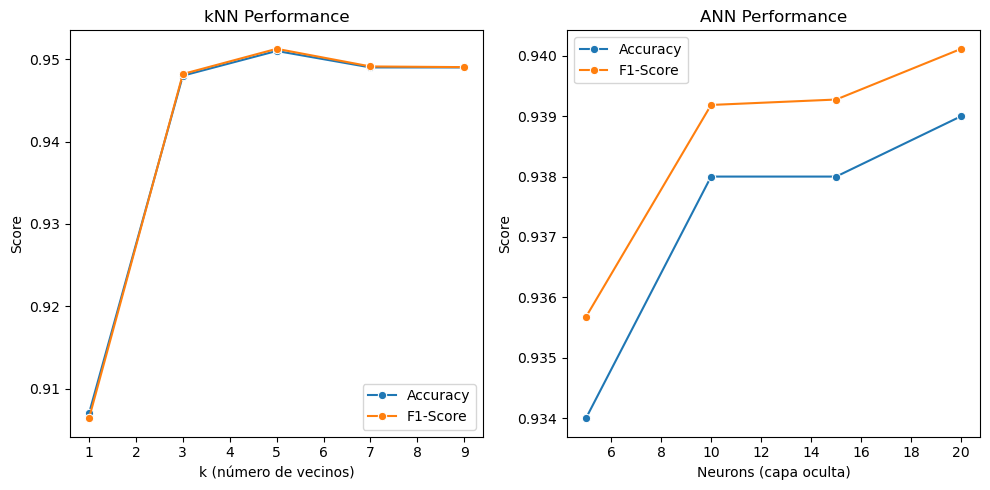

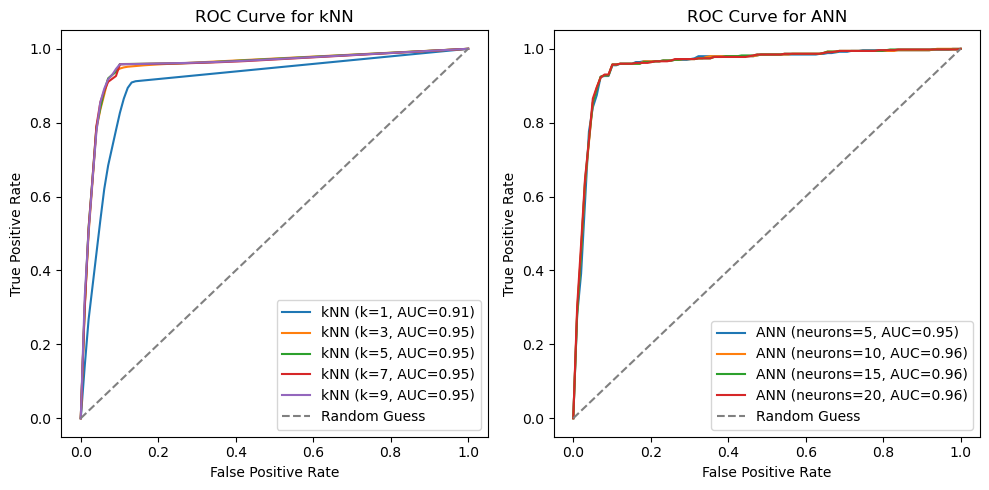

In [9]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Cargar el conjunto de datos
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# exploramos los datos
print(data.describe())
sns.pairplot(data, hue='y', diag_kind='kde')
plt.show()

# normalizamos
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data.iloc[:, :-1])
normalized_data = pd.DataFrame(scaled_features, columns=data.columns[:-1])
normalized_data['y'] = data['y']

# Configurar validación cruzada k-fold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Implementación de kNN ---
k_values = [1, 3, 5, 7, 9]
k_scores = {"k": [], "accuracy": [], "f1": []}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy = cross_val_score(knn, normalized_data.iloc[:, :-1], normalized_data['y'], 
                                cv=kfold, scoring=make_scorer(accuracy_score)).mean()
    f1 = cross_val_score(knn, normalized_data.iloc[:, :-1], normalized_data['y'], 
                         cv=kfold, scoring=make_scorer(f1_score, pos_label='B')).mean()
    k_scores["k"].append(k)
    k_scores["accuracy"].append(accuracy)
    k_scores["f1"].append(f1)

knn_results = pd.DataFrame(k_scores)
print("Resultados de kNN:")
print(knn_results)

# --- Implementación de ANN ---
hidden_layer_sizes = [5, 10, 15, 20]
ann_scores = {"neurons": [], "accuracy": [], "f1": []}

for size in hidden_layer_sizes:
    ann = MLPClassifier(hidden_layer_sizes=(size,), max_iter=1000, random_state=42)
    accuracy = cross_val_score(ann, normalized_data.iloc[:, :-1], normalized_data['y'], 
                                cv=kfold, scoring=make_scorer(accuracy_score)).mean()
    f1 = cross_val_score(ann, normalized_data.iloc[:, :-1], normalized_data['y'], 
                         cv=kfold, scoring=make_scorer(f1_score, pos_label='B')).mean()
    ann_scores["neurons"].append(size)
    ann_scores["accuracy"].append(accuracy)
    ann_scores["f1"].append(f1)

ann_results = pd.DataFrame(ann_scores)
print("Resultados de ANN:")
print(ann_results)

# --- Comparación de resultados ---
plt.figure(figsize=(10, 5))

# Gráfico para kNN
plt.subplot(1, 2, 1)
sns.lineplot(x=knn_results["k"], y=knn_results["accuracy"], label="Accuracy", marker='o')
sns.lineplot(x=knn_results["k"], y=knn_results["f1"], label="F1-Score", marker='o')
plt.title("kNN Performance")
plt.xlabel("k (número de vecinos)")
plt.ylabel("Score")
plt.legend()

# Gráfico para ANN
plt.subplot(1, 2, 2)
sns.lineplot(x=ann_results["neurons"], y=ann_results["accuracy"], label="Accuracy", marker='o')
sns.lineplot(x=ann_results["neurons"], y=ann_results["f1"], label="F1-Score", marker='o')
plt.title("ANN Performance")
plt.xlabel("Neurons (capa oculta)")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()


# --- Curvas ROC y AUC para kNN ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train_index, test_index in kfold.split(normalized_data):
        X_train, X_test = normalized_data.iloc[train_index, :-1], normalized_data.iloc[test_index, :-1]
        y_train, y_test = normalized_data.iloc[train_index, -1], normalized_data.iloc[test_index, -1]
        
        knn.fit(X_train, y_train)
        y_proba = knn.predict_proba(X_test)[:, 1]  # Probabilidad para la clase positiva
        
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='B')
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc(fpr, tpr))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f'kNN (k={k}, AUC={mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title("ROC Curve for kNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# --- Curvas ROC y AUC para ANN ---
plt.subplot(1, 2, 2)

for size in hidden_layer_sizes:
    ann = MLPClassifier(hidden_layer_sizes=(size,), max_iter=1000, random_state=42)
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train_index, test_index in kfold.split(normalized_data):
        X_train, X_test = normalized_data.iloc[train_index, :-1], normalized_data.iloc[test_index, :-1]
        y_train, y_test = normalized_data.iloc[train_index, -1], normalized_data.iloc[test_index, -1]
        
        ann.fit(X_train, y_train)
        y_proba = ann.predict_proba(X_test)[:, 1]  # Probabilidad para la clase positiva
        
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='B')
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(auc(fpr, tpr))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f'ANN (neurons={size}, AUC={mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title("ROC Curve for ANN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()

